In [1]:
!unzip dataset.zip


Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
   creating: dataset/training/
   creating: dataset/validation/
  inflating: dataset/training/data.json  
   creating: dataset/training/outputs/
   creating: dataset/training/inputs/
  inflating: dataset/validation/data.json  
   creating: dataset/validation/outputs/
   creating: dataset/validation/inputs/
  inflating: dataset/training/outputs/green_octagon.png  
  inflating: dataset/training/outputs/blue_hexagon.png  
  inflating: dataset/training/outputs/green_diamond.png  
  inflating: dataset/training/outputs/cyan_triangle.png  
  inflating: dataset/training/outputs/purple_square.png  
  inflating: dataset/training/outputs/orange_pentagon.png  
  inflating: dataset/training/outputs/magenta_circle.png  
  inflating: dataset/training/outputs/blue_triangle.png  
  inflating: dataset/training/outputs/red_pentagon.png  
  inflating: dataset/training/outputs/magen

In [2]:
import os
import json
import torch
import wandb
import random
import torchvision.transforms as T
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm


In [3]:
import os
import json
import torch
import wandb
import random
import torchvision.transforms as T
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

class PolygonColorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.input_dir = os.path.join(root_dir, "inputs")
        self.output_dir = os.path.join(root_dir, "outputs")
        with open(os.path.join(root_dir, "data.json"), "r") as f:
            self.data = json.load(f)
        self.transform = transform
        self.color_dict = {
            "red": (1, 0, 0),
            "green": (0, 1, 0),
            "blue": (0, 0, 1),
            "yellow": (1, 1, 0),
            "purple": (1, 0, 1),
            "cyan": (0, 1, 1),
            "black": (0, 0, 0),
            "white": (1, 1, 1),
            "orange": (1, 0.5, 0), # Added orange
            "magenta": (1, 0, 1) # Added magenta
        }


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        input_img = Image.open(os.path.join(self.input_dir, entry["input_polygon"])).convert("L")
        output_img = Image.open(os.path.join(self.output_dir, entry["output_image"])).convert("RGB")
        color_vec = torch.tensor(self.color_dict[entry["colour"]], dtype=torch.float32)

        if self.transform:
            input_img = self.transform(input_img)
            output_img = self.transform(output_img)

        return input_img, color_vec, output_img

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_ch=1, cond_ch=3, out_ch=3):
        super().__init__()
        self.enc1 = ConvBlock(in_ch + cond_ch, 64)
        self.enc2 = ConvBlock(64, 128)
        self.pool = nn.MaxPool2d(2)
        self.dec1 = ConvBlock(128, 64)
        self.final = nn.Conv2d(64, out_ch, 1)

    def forward(self, x, cond):
        cond = cond.view(cond.shape[0], cond.shape[1], 1, 1)
        cond = cond.expand(-1, -1, x.shape[2], x.shape[3])
        x = torch.cat([x, cond], dim=1)
        x1 = self.enc1(x)
        x2 = self.pool(x1)
        x3 = self.enc2(x2)
        x4 = nn.functional.interpolate(x3, scale_factor=2, mode='bilinear', align_corners=False)
        x5 = self.dec1(x4)
        return self.final(x5)

In [5]:
def train():
    wandb.init(project="polygon-color-unet")

    transform = T.Compose([
        T.Resize((128, 128)),
        T.ToTensor()
    ])

    train_dataset = PolygonColorDataset("dataset/training", transform)
    val_dataset = PolygonColorDataset("dataset/validation", transform)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(15):
        model.train()
        running_loss = 0.0
        for img, cond, target in tqdm(train_loader):
            img, cond, target = img.to(device), cond.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(img, cond)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        wandb.log({"train_loss": avg_loss})

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for img, cond, target in val_loader:
                img, cond, target = img.to(device), cond.to(device), target.to(device)
                output = model(img, cond)
                loss = criterion(output, target)
                val_loss += loss.item()
        wandb.log({"val_loss": val_loss / len(val_loader)})

        print(f"Epoch [{epoch+1}/15], Loss: {avg_loss:.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

    torch.save(model.state_dict(), "unet_colored_polygon.pth")

if __name__ == "__main__":
    train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: girisanskruti0404 (girisanskruti0404-national-institute-of-technology-patna) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


Epoch [1/15], Loss: 0.6268, Val Loss: 0.4755


100%|██████████| 7/7 [00:00<00:00, 23.96it/s]


Epoch [2/15], Loss: 0.5503, Val Loss: 0.5590


100%|██████████| 7/7 [00:00<00:00, 24.39it/s]


Epoch [3/15], Loss: 0.3376, Val Loss: 0.1534


100%|██████████| 7/7 [00:00<00:00, 24.12it/s]


Epoch [4/15], Loss: 0.1444, Val Loss: 0.1110


100%|██████████| 7/7 [00:00<00:00, 24.43it/s]


Epoch [5/15], Loss: 0.1233, Val Loss: 0.0852


100%|██████████| 7/7 [00:00<00:00, 24.62it/s]


Epoch [6/15], Loss: 0.1045, Val Loss: 0.0718


100%|██████████| 7/7 [00:00<00:00, 24.49it/s]


Epoch [7/15], Loss: 0.0979, Val Loss: 0.0694


100%|██████████| 7/7 [00:00<00:00, 24.44it/s]


Epoch [8/15], Loss: 0.0939, Val Loss: 0.0744


100%|██████████| 7/7 [00:00<00:00, 24.86it/s]


Epoch [9/15], Loss: 0.0905, Val Loss: 0.0664


100%|██████████| 7/7 [00:00<00:00, 24.61it/s]


Epoch [10/15], Loss: 0.0926, Val Loss: 0.0618


100%|██████████| 7/7 [00:00<00:00, 24.20it/s]


Epoch [11/15], Loss: 0.0871, Val Loss: 0.0625


100%|██████████| 7/7 [00:00<00:00, 24.65it/s]


Epoch [12/15], Loss: 0.0857, Val Loss: 0.0582


100%|██████████| 7/7 [00:00<00:00, 24.61it/s]


Epoch [13/15], Loss: 0.0828, Val Loss: 0.0596


100%|██████████| 7/7 [00:00<00:00, 24.00it/s]


Epoch [14/15], Loss: 0.0810, Val Loss: 0.0590


100%|██████████| 7/7 [00:00<00:00, 24.68it/s]

Epoch [15/15], Loss: 0.0814, Val Loss: 0.0593


In [6]:
import json

with open("dataset/training/data.json", "r") as f:
    data_sample = json.load(f)

# Print the first entry to inspect its structure
print(data_sample[0])

{'input_polygon': 'octagon.png', 'colour': 'cyan', 'output_image': 'cyan_octagon.png'}


In [9]:
import os

val_images = os.listdir("dataset/validation/inputs")
print(val_images)


['triangle.png', 'octagon.png', 'star.png', 'square.png']


In [23]:
import torch
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os

# Load your model architecture
class ConvBlock(torch.nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(in_ch, out_ch, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_ch, out_ch, 3, padding=1),
            torch.nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)

class UNet(torch.nn.Module):
    def __init__(self, in_ch=1, cond_ch=3, out_ch=3):
        super().__init__()
        self.enc1 = ConvBlock(in_ch + cond_ch, 64)
        self.enc2 = ConvBlock(64, 128)
        self.pool = torch.nn.MaxPool2d(2)
        self.dec1 = ConvBlock(128, 64)
        self.final = torch.nn.Conv2d(64, out_ch, 1)

    def forward(self, x, cond):
        cond = cond.view(cond.shape[0], cond.shape[1], 1, 1)
        cond = cond.expand(-1, -1, x.shape[2], x.shape[3])
        x = torch.cat([x, cond], dim=1)
        x1 = self.enc1(x)
        x2 = self.pool(x1)
        x3 = self.enc2(x2)
        x4 = torch.nn.functional.interpolate(x3, scale_factor=2, mode='bilinear', align_corners=False)
        x5 = self.dec1(x4)
        return self.final(x5)

# Load trained model
model = UNet()
model.load_state_dict(torch.load("unet_colored_polygon.pth", map_location="cpu"))
model.eval()

# Color dictionary
color_dict = {
    "red": (1, 0, 0),
    "green": (0, 1, 0),
    "blue": (0, 0, 1),
    "yellow": (1, 1, 0),
    "purple": (1, 0, 1),
    "cyan": (0, 1, 1),
    "black": (0, 0, 0),
    "white": (1, 1, 1),
    "orange": (1, 0.5, 0), # Added orange
    "magenta": (1, 0, 1)
}

# Define function to perform inference and display results
def predict_and_display(input_polygon_filename, color_name):
    try:
        input_img_path = os.path.join("dataset/validation/inputs", input_polygon_filename)
        print(f"Loading input image from: {input_img_path}")
        img = Image.open(input_img_path).convert("L")

        transform = T.Compose([
            T.Resize((128, 128)),
            T.ToTensor()
        ])
        img_tensor = transform(img).unsqueeze(0)

        print(f"Using color: {color_name}")
        color_tensor = torch.tensor([color_dict[color_name]]).float()

        # Predict
        with torch.no_grad():
            output = model(img_tensor, color_tensor)
        print("Inference complete.")
        print(f"Output tensor shape: {output.shape}, dtype: {output.dtype}")


        # Show result
        output_img = T.ToPILImage()(output.squeeze(0))
        print("Converted output tensor to PIL Image.")

        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(output_img)
        plt.title("Input Polygon")
        plt.axis("off")
        plt.subplot(1,2,2)
        plt.imshow(output_img)
        plt.title(f"Predicted Color: {color_name}")
        plt.axis("off")
        plt.show()
        print("Images displayed.")

    except Exception as e:
        print(f"An error occurred during prediction or display: {e}")


# Example usage:
# predict_and_display("triangle.png", "red")
# predict_and_display("octagon.png", "blue")
# predict_and_display("square.png", "green")

Loading input image from: dataset/validation/inputs/triangle.png
Using color: green
Inference complete.
Output tensor shape: torch.Size([1, 3, 128, 128]), dtype: torch.float32
Converted output tensor to PIL Image.


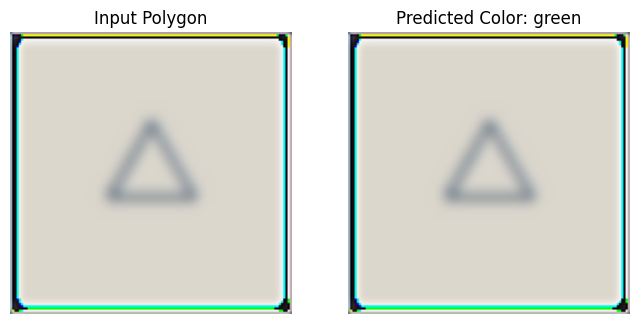

Images displayed.


In [25]:
predict_and_display("triangle.png", "green")


In [26]:
# 📦 Install & Login to WandB (Run this once per Colab session)
!pip install -q wandb
import wandb
wandb.login()



wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

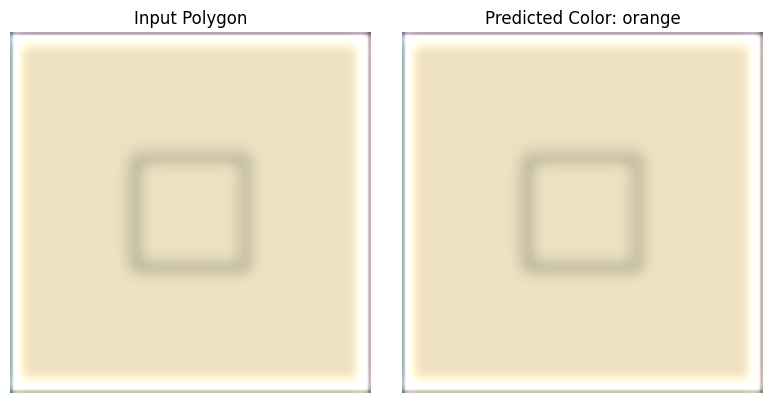

Blue Channel Mean,▁
Green Channel Mean,▁
Red Channel Mean,▁
Blue Channel Mean,0.7793
Green Channel Mean,0.89114
Red Channel Mean,0.93365


In [31]:
# 🧠 Imports
import torch
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os

# 🏗️ UNet Model Definition
class ConvBlock(torch.nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(in_ch, out_ch, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_ch, out_ch, 3, padding=1),
            torch.nn.ReLU()
        )
    def forward(self, x):
        return self.block(x)

class UNet(torch.nn.Module):
    def __init__(self, in_ch=1, cond_ch=3, out_ch=3):
        super().__init__()
        self.enc1 = ConvBlock(in_ch + cond_ch, 64)
        self.enc2 = ConvBlock(64, 128)
        self.pool = torch.nn.MaxPool2d(2)
        self.dec1 = ConvBlock(128, 64)
        self.final = torch.nn.Conv2d(64, out_ch, 1)

    def forward(self, x, cond):
        cond = cond.view(cond.shape[0], cond.shape[1], 1, 1)
        cond = cond.expand(-1, -1, x.shape[2], x.shape[3])
        x = torch.cat([x, cond], dim=1)
        x1 = self.enc1(x)
        x2 = self.pool(x1)
        x3 = self.enc2(x2)
        x4 = torch.nn.functional.interpolate(x3, scale_factor=2, mode='bilinear', align_corners=False)
        x5 = self.dec1(x4)
        return self.final(x5)

# 🎯 Initialize WandB Run
wandb.init(
    project="colored-polygon-unet",
    name="inference-debug-session",
    job_type="inference"
)

# 🎨 Color Dictionary
color_dict = {
    "red": (1, 0, 0),
    "green": (0, 1, 0),
    "blue": (0, 0, 1),
    "yellow": (1, 1, 0),
    "purple": (1, 0, 1),
    "cyan": (0, 1, 1),
    "black": (0, 0, 0),
    "white": (1, 1, 1),
    "orange": (1, 0.5, 0),
    "magenta": (1, 0, 1)
}

# 📥 Load Model
model = UNet()
model.load_state_dict(torch.load("unet_colored_polygon.pth", map_location="cpu"))
model.eval()

# 🔍 Prediction + WandB Logging Function
def predict_and_display(input_polygon_filename, color_name):
    try:
        input_img_path = os.path.join("dataset/validation/inputs", input_polygon_filename)
        assert os.path.exists(input_img_path), f"❌ File not found: {input_img_path}"

        img = Image.open(input_img_path).convert("L")

        transform = T.Compose([
            T.Resize((128, 128)),
            T.ToTensor()
        ])
        img_tensor = transform(img).unsqueeze(0)

        assert color_name in color_dict, f"❌ Color '{color_name}' not in color_dict!"
        color_tensor = torch.tensor([color_dict[color_name]]).float()

        with torch.no_grad():
            output = model(img_tensor, color_tensor)

        # Clamp & convert to image
        output = torch.clamp(output, 0.0, 1.0)
        output_img = T.ToPILImage()(output.squeeze(0))

        # 🎯 Log to WandB
        wandb.log({
            "Input Polygon": wandb.Image(img, caption="Input Grayscale"),
            "Predicted Output": wandb.Image(output_img, caption=f"Color: {color_name}"),
            "Red Channel Mean": output[0, 0].mean().item(),
            "Green Channel Mean": output[0, 1].mean().item(),
            "Blue Channel Mean": output[0, 2].mean().item()
        })

        # 🖼️ Show images
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(output_img)
        plt.title("Input Polygon")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(output_img)
        plt.title(f"Predicted Color: {color_name}")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f" Error: {e}")

# Example usage:
predict_and_display("square.png", "orange")

# Finish WandB run
wandb.finish()
